## Objectives
- Side quests에 이어서 main quest 플레이 시간을 proxy 해보고자 한다.
- 로그인 시간은 알아도, 로그아웃 시간을 모르기 때문에, 바로 다음 로그인 직전 발생한 마지막 transation timestamp를 활용하고자 했다.
- 이 노트북은 특히 미완이고, 개선의 여지가 많으며, 이후 노트북에서 아직 활용하고 있지는 않다.

In [1]:
from config import *

In [2]:
levelups_ref = pd.read_csv("../data/levelups_panel_2.csv", encoding="utf-8")
levelups_ref["event_datetime"] = pd.to_datetime(levelups_ref["event_datetime"])
levelups_ref["event_datetime_prev"] = pd.to_datetime(levelups_ref["event_datetime_prev"])
levelups_ref = levelups_ref.sort_values(by=["event_datetime_prev","event_datetime","level_from"]).reset_index(drop=True) # several leveups can happen at once

### Login history

In [4]:
l_sample = levelups_ref.player_slug.unique()

In [5]:
# login history: character
logins = pd.read_csv("../data/characters_login.csv", encoding="utf-8")
logins.drop(columns=["id","player_id","character_id","event_timestamp"], inplace=True)
logins = simple_preprocess(logins)

logins = logins.query("player_slug in @l_sample").reset_index(drop=True)

### Playing logs

In [6]:
# purchase history
purchases = pd.read_csv("../data/purchases.csv", encoding="utf-8")[["player_slug","character_slug","event_datetime"]]
purchases = simple_preprocess(purchases)
purchases = purchases.query("player_slug in @l_sample").reset_index(drop=True)

# ads watching history
ads = pd.read_csv("../data/characters_ads.csv", encoding="utf-8")[["player_slug","character_slug","event_datetime"]]
ads = simple_preprocess(ads)
ads = ads.query("player_slug in @l_sample").reset_index(drop=True)

# stages
stages = pd.read_csv("../data/stages.csv", encoding="utf-8")[["player_slug","character_slug","event_datetime"]]
stages["event_datetime"] = pd.to_datetime(stages["event_datetime"])
stages = stages.query("player_slug in @l_sample").reset_index(drop=True)

In [7]:
# currency get history
cur_get = pd.read_csv("../data/characters_currencies_get.csv", encoding="utf-8")[["player_slug","character_slug","event_datetime"]]
cur_get = simple_preprocess(cur_get)
cur_get = cur_get.query("player_slug in @l_sample").reset_index(drop=True)
cur_get = cur_get.query("character_slug!='_DUMMY_CHARACTER_ID_'").reset_index(drop=True)

# consumable get history
con_get = pd.read_csv("../data/characters_items_consumable_get.csv", encoding="utf-8")[["player_slug","character_slug","event_datetime"]]
con_get = simple_preprocess(con_get)
con_get = con_get.query("player_slug in @l_sample").reset_index(drop=True)

# skill equipment history
skill_eq = pd.read_csv("../data/characters_skills_equip.csv", encoding="utf-8")[["player_slug","character_slug","event_datetime"]]
skill_eq = simple_preprocess(skill_eq)
skill_eq = skill_eq.query("player_slug in @l_sample").reset_index(drop=True)

# skill equipment history
skill_lv = pd.read_csv("../data/characters_skills_levelup.csv", encoding="utf-8")[["player_slug","character_slug","event_datetime"]]
skill_lv = simple_preprocess(skill_lv)
skill_lv = skill_lv.query("player_slug in @l_sample").reset_index(drop=True)

# stat change history
stat = pd.read_csv("../data/characters_stats_change.csv", encoding="utf-8")[["player_slug","character_slug","event_datetime"]]
stat = simple_preprocess(stat)
stat = stat.query("player_slug in @l_sample").reset_index(drop=True)

In [8]:
tx = pd.concat([purchases, ads, stages, cur_get, con_get, skill_eq, skill_lv, stat])
tx = tx.sort_values(by="event_datetime").reset_index(drop=True)

In [9]:
del stages, cur_get, con_get, skill_eq, skill_lv, stat

### Main quests playing time in hours

* <code>playtime_main</code>: Actual playing time of the main quest in hours before progressing to the next level

In [10]:
# 가장 가까운 로그인
tmp = logins.copy()
tmp.rename(columns={"event_datetime":"event_datetime_prev"}, inplace=True)
tmp["login_dt_1"] = tmp["event_datetime_prev"]
levelups_ref = pd.merge_asof(levelups_ref, tmp, on="event_datetime_prev", by=["player_slug","character_slug"],
                             direction="forward", allow_exact_matches=False)

In [11]:
print(len(levelups_ref.query("event_datetime <= login_dt_1")))
print(len(levelups_ref.query("event_datetime > login_dt_1")))

1574633
93431


* 레벨업하는 데까지 소요된 시간(interval) 중에 새로운 로그인(login_dt_1)이 없었던 경우

In [12]:
levelups_ref_comp = levelups_ref.query("event_datetime <= login_dt_1").copy()
print(levelups_ref_comp.player_slug.nunique())

# 인터벌에서 사이드 플레이 시간 제외
levelups_ref_comp["playtime_main"] = levelups_ref_comp["interval"] - levelups_ref_comp["playtime_side"]

30087


In [13]:
# 로그인 기록 누락 의심되는 플레이어들
l_error = []

# 레벨 100 아래에서 1.5시간 넘게 소요된 플레이어
l_error = l_error + levelups_ref_comp.query("level_to<100 & playtime_main>1.5").player_slug.unique().tolist()
print(len(list(set(l_error))))

# 레벨 150 아래에서 3시간 넘게 소요된 플레이어
l_error = l_error + levelups_ref_comp.query("100<=level_to<150 & playtime_main>3").player_slug.unique().tolist()
print(len(list(set(l_error))))

# 레벨 200 아래에서 6시간 넘게 소요된 플레이어
l_error = l_error + levelups_ref_comp.query("150<=level_to<200 & playtime_main>6").player_slug.unique().tolist()
print(len(list(set(l_error))))

# 레벨 250 아래에서 12시간 넘게 소요된 플레이어
l_error = l_error + levelups_ref_comp.query("150<=level_to<200 & playtime_main>12").player_slug.unique().tolist()
print(len(list(set(l_error))))

3329
3908
3939
3939


In [14]:
# 로그인 오류 의심 플레이어 제외
levelups_ref = levelups_ref.query("player_slug not in @l_error").reset_index(drop=True)

levelups_ref_comp = levelups_ref.query("event_datetime <= login_dt_1").copy()
levelups_ref_comp["playtime_main"] = levelups_ref_comp["interval"] - levelups_ref_comp["playtime_side"]

In [15]:
levelups_ref_comp.drop(columns=["login_dt_1"], inplace=True)

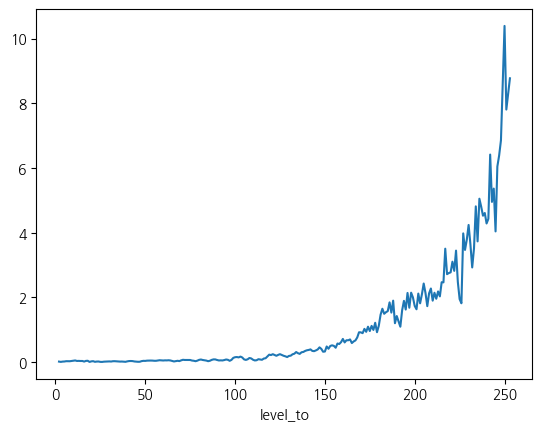

In [16]:
levelups_ref_comp.groupby("level_to")["playtime_main"].mean().plot()
plt.show()

* 레벨업하는 데까지 소요된 시간(interval) 중에 새로운 로그인(login_dt_1)이 있었던 경우

In [17]:
levelups_ref_prog = levelups_ref.query("event_datetime > login_dt_1").copy()
levelups_ref_prog.player_slug.nunique()

24280

In [18]:
# 새로운 로그인 기록이 불필요하게 찍혔다고 판단되는 경우
l_error = []

# 레벨 100 아래에서 1.5시간 아래 소요된 플레이어
l_error = l_error + levelups_ref_prog.query("level_to<100 & interval<=1.5").index.tolist()
print(len(l_error))

# 레벨 150 아래에서 3시간 아래 소요된 플레이어
l_error = l_error + levelups_ref_prog.query("100<=level_to<150 & interval<=3").index.tolist()
print(len(l_error))

# 레벨 200 아래에서 6시간 아래 소요된 플레이어
l_error = l_error + levelups_ref_prog.query("150<=level_to<200 & interval<=6").index.tolist()
print(len(l_error))

# 레벨 250 아래에서 12시간 아래 소요된 플레이어
l_error = l_error + levelups_ref_prog.query("200<=level_to<250 & interval<=12").index.tolist()
print(len(l_error))


# 위 행들은 그냥 levelups_ref_comp에 결합
levelups_ref_prog_comp = levelups_ref_prog.loc[l_error]
levelups_ref_prog_comp["playtime_main"] = levelups_ref_prog_comp["interval"] - levelups_ref_prog_comp["playtime_side"]
levelups_ref_prog_comp.drop(columns=["login_dt_1"], inplace=True)
levelups_ref_comp = pd.concat([levelups_ref_comp, levelups_ref_prog_comp]).sort_index()

19730
23090
23975
24195


In [19]:
# 여전히 문제가 되는 행들
levelups_ref_prog = levelups_ref_prog.drop(l_error)

1) 다음 로그인이 있는지 체크 (단, 다음 로그인이 있다면 < event_datetime / 없다면 event_datetime - 본 로그인 사이 시간을 playtime_main에 추가)
2) 이전 활동이 있는지 체크 (단, event_datetime_prev (혹은 직전 로그인) < 이전 활동 / 아니면 에러 처리)
3) 이전 활동 - event_datetime_prev (혹은 직전 로그인) 사이 시간을 playtime_main에 추가

In [20]:
def check_too_long_playing_time(lv, ptime):
    if lv<100 and ptime>1.5:
        return 1
    elif lv<150 and ptime>3:
        return 1
    elif lv<200 and ptime>6:
        return 1
    elif lv<250 and ptime>12:
        return 1
    else:
        return 0

In [21]:
def calculate_actual_playing_time(row):
    playtime = 0
    
    # 중간에 발생한 로그인들
    logins_ = logins.query("player_slug==@row.player_slug & @row.event_datetime_prev<event_datetime<@row.event_datetime")
    logins_ = logins_[["event_datetime"]].reset_index(drop=True)
    
    # 로그인이 1번만 발생한 경우
    if len(logins_)==1:
        # 해당 로그인 이전 가장 마지막으로 발생한 play log
        tx_datetime = tx.query("player_slug==@row.player_slug & @row.event_datetime_prev<event_datetime<@logins_.event_datetime.min()")
        tx_datetime = tx_datetime["event_datetime"].max()
        
        p1 = (tx_datetime - row["event_datetime_prev"]).total_seconds() / 3600
        if p1==p1 and check_too_long_playing_time(row["level_to"], p1)==0:
            playtime += p1
        elif p1==p1 and check_too_long_playing_time(row["level_to"], p1)==1:
            playtime += 100000
        
        p2 = (row["event_datetime"] - logins_["event_datetime"].min()).total_seconds() / 3600
        if p2==p2 and check_too_long_playing_time(row["level_to"], p2)==0:
            playtime += p2
        elif p2==p2 and check_too_long_playing_time(row["level_to"], p2)==1:
            playtime += 100000
    
    # 로그인 2번 이상 발생한 경우
    else:
        login_datetime_prev = row["event_datetime_prev"]
        for login_idx, login_row in logins_.iterrows():
            # 해당 로그인 이전 가장 마지막으로 발생한 play log
            tx_datetime = tx.query("player_slug==@row.player_slug & @login_datetime_prev<event_datetime<@login_row.event_datetime")
            tx_datetime = tx_datetime["event_datetime"].max()
            
            pn = (tx_datetime - login_datetime_prev).total_seconds() / 3600
            if pn==pn and check_too_long_playing_time(row["level_to"], pn)==0:
                playtime += pn
            elif pn==pn and check_too_long_playing_time(row["level_to"], pn)==1:
                playtime += 100000
            
            login_datetime_prev = login_row["event_datetime"]
        
        # 가장 마지막 로그인 ~ event_datetime
        pf = (row["event_datetime"] - logins_["event_datetime"].max()).total_seconds() / 3600
        if pf==pf and check_too_long_playing_time(row["level_to"], pf)==0:
            playtime += pf
        elif pf==pf and check_too_long_playing_time(row["level_to"], pf)==1:
            playtime += 100000
    
    return playtime - row["playtime_side"]

In [22]:
levelups_ref_prog["playtime_main"] = levelups_ref_prog.progress_apply(calculate_actual_playing_time, axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 47254/47254 [3:13:05<00:00,  4.08it/s]


In [23]:
levelups_ref_prog.drop(columns=["login_dt_1"], inplace=True)

In [24]:
# 로그인 오류 의심 플레이어 제외
l_error = levelups_ref_prog.query("playtime_main>10000").player_slug.unique()
print(len(l_error))

levelups_ref_comp = levelups_ref_comp.query("player_slug not in @l_error").reset_index(drop=True)
levelups_ref_prog = levelups_ref_prog.query("player_slug not in @l_error").reset_index(drop=True)

1456


### Concatenation

In [25]:
levelups_ref_3 = pd.concat([levelups_ref_comp, levelups_ref_prog]).sort_index().reset_index(drop=True)

In [26]:
levelups_ref_3["player_slug"].nunique()

25668

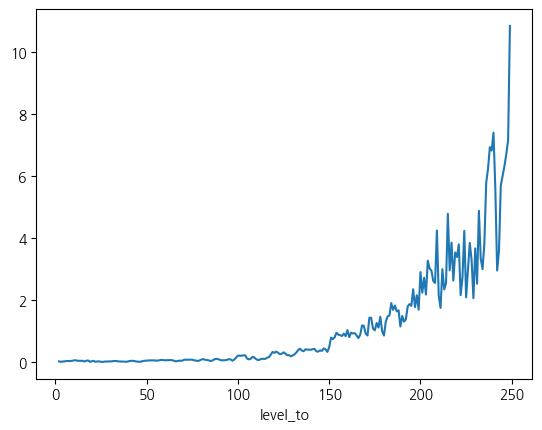

In [27]:
levelups_ref_3.groupby("level_to")["playtime_main"].mean().plot()
plt.show()

In [28]:
# final check: playtime more than 12 hours
l_error = levelups_ref_3.query("playtime_main > 12")["player_slug"].unique()
print(len(l_error))

levelups_ref_3 = levelups_ref_3.query("player_slug not in @l_error").reset_index(drop=True)

1


In [29]:
levelups_ref_3["playtime_main"].describe()

count    1.141203e+06
mean     5.853241e-02
std      2.056963e-01
min      2.777778e-04
25%      9.722222e-03
50%      2.305556e-02
75%      4.055556e-02
max      1.190222e+01
Name: playtime_main, dtype: float64

* Export

In [7]:
levelups_ref_3.to_csv("../data/levelups_panel_3.csv", index=None, encoding="utf-8")